In [1]:
import pandas as pd
import seaborn as sns
import re

In [2]:
#Variables
SSRMMD = '/opt/biotools/SSRMMD-master/SSRMMD.pl'
PRIMER3 = '/opt/biotools/SSRMMD-master/connectorToPrimer3/connectorToPrimer3.pl'
THREADS = '8'
REPEATS = ['DI', 'TRI', 'TETRA', 'PENTA', 'SIX']
GROUP = [2, 3, 4, 5, 6]


In [4]:
#BUSCAR MICROSATELITES
GENOMA = 'REGINA.fasta'
OUTPUT = 'ALL'

cmd = f'{SSRMMD} -f1 REFERENCIAS/{GENOMA} -p 0 -o SSR/{OUTPUT} -t {THREADS} -mo 2=7,3=4,4=4,5=4,6=4 -ss 1'
#!perl {cmd}


In [6]:
df_ssr = pd.read_csv(f'SSR/{OUTPUT}/{GENOMA}.SSRs', delimiter="\t")

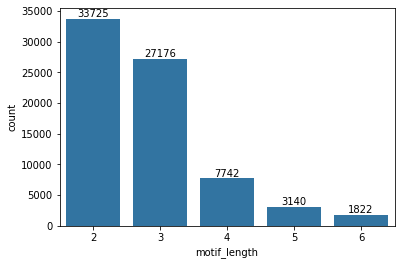

In [7]:
countplot = sns.countplot(data=df_ssr, x='motif_length')
countplot.bar_label(countplot.containers[0], fontsize=10);

In [8]:
motif = df_ssr.groupby('motif_length')
for key, group in motif:
    group.to_csv(f'SSR/Motif{key}.tsv', sep="\t", index=False)

In [10]:
motif.get_group(2)['motif'].value_counts()

motif
AT    6969
TA    5371
CT    4848
GA    4783
AG    4734
TC    4609
TG     738
CA     640
AC     595
GT     432
GC       5
CG       1
Name: count, dtype: int64

In [34]:
#PRIMERS
SIZE_RANGE = '100-300'
GC = '45,60'
TM = '57,60,63'
!perl {PRIMER3} -i SSR/{OUTPUT}/{GENOMA}.SSRs -o PRIMERS/{OUTPUT}_PRIMERS.tsv -us {SIZE_RANGE} -gc {GC} -tm {TM}

In [69]:
#PRIMERS POR GRUPO
for x in GROUP:
    !perl {PRIMER3} -i SSR/Motif{x}.tsv -o PRIMERS/Motif{x}_PRIMERS.tsv -us {SIZE_RANGE} -gc {GC} -tm {TM}
    

In [72]:
NAME='Motif6'

df_primers = pd.read_csv(f'PRIMERS/{NAME}_PRIMERS.tsv', delimiter="\t")
duplicatePrimers = df_primers[df_primers.duplicated(['forward_primer','reverse_primer'])]
duplicatePrimers.to_csv(f'PRIMERS/{NAME}_PRIMERS_DUPLICADOS.tsv', sep="\t", index=False)
filterPrimers = df_primers.drop_duplicates(subset=['forward_primer','reverse_primer'])
filterPrimers.to_csv(f'PRIMERS/{NAME}_PRIMERS_FILTER.tsv', sep="\t", index=False)
#primer_filtrado = df_primers[df_primers.drop_duplicates(subset=['forward_primer','reverse_primer'],keep=False)]
#primer_filtrado.info()
#df_primers_filter = df_primers[['id','forward_primer','reverse_primer']]
#df_primers_filter

In [80]:
ipcress_primers = filterPrimers[['id','forward_primer','reverse_primer']]
ipcress_primers['Min']='100'
ipcress_primers['Max']='500'
ipcress_primers.to_csv(f'PRIMERS/IPCRESS/{NAME}_ipcress.tsv', sep="\t", index=False)

/tmp/ipykernel_6572/3038388921.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ipcress_primers['Min']='100'
/tmp/ipykernel_6572/3038388921.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ipcress_primers['Max']='500'


In [4]:
!ipcress ./PRIMERS/IPCRESS/Motif6_ipcress.tsv ./REFERENCIAS/REGINA.fasta > ./IPCRESS/primer_sets.ipcress.out

** Message: 02:35:05.422: Loaded [949] experiments


In [8]:
ipcress_header=['sequence_id', 'primer_id','product_length','primer_5','pos_5', 'mismatch_5', 'primer_3', 'pos_3', 'mismatch_3', 'description']
result = []
amplicon = [line for line in open('./IPCRESS/primer_sets.ipcress.out') if re.match(r'^ipcress:', line)]
aux = [x.split() for x in amplicon]
for item in aux:
    result.append([item[1].split(":")[0], item[2], item[3], item[4], item[5], item[6], item[7], item[8], item[9], item[10]])

ePCR_hits=pd.DataFrame(result, columns=ipcress_header)


In [21]:
ePCR = ePCR_hits.drop(ePCR_hits[(ePCR_hits['description'] == 'single_A') |(ePCR_hits['description'] == 'single_B')].index)
#ePCR.to_csv('amplicones2.tsv', sep="\t", index=False)

countPrimers = dict(ePCR['primer_id'].value_counts())

filtro_amplificacion = { key:value for (key, value) in countPrimers.items()  if value >= 3 and value <= 8 }
primers_selecionados = list(filtro_amplificacion.keys())


41